# Data Transformations

This notebook contains code to:
- read data about trending USA videos from the initial dataset
- transform dataset using NLTK and TextVectorization and split it into train and test sets
- create Embedding layers using pretrained fastText embeddings
- save all the necessary information for future use

## Imports

In [1]:
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import nltk

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

## Download nltk data

In [2]:
# to use nltk.corpus.words.words()
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\dmytro\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [3]:
# to use nltk.tokenize.word_tokenize(string)
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dmytro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Helper functions

In [4]:
def read_ids(filename):
    """ Read ids from file to list """

    with open(filename, 'r') as f:
        ids = f.read().splitlines()

    return ids

In [5]:
def create_vectorizer(text, max_tokens=10000, sentence_length=1000):
    """ 
    Create TextVectorization() layer based on the text

    Parameters:
        text (array of strings): text
        max_tokens (int): size of the vocabulary.
            The layer will consider only 'max_tokens' top popular words
        sentence_length (int): maximum number of words in a sentence.
            Longer sentences will be truncated, shorter ones will be pad

    Returns:
        vectorizer layer (tf.keras.layers.TextVectorization)
    """

    vectorizer = layers.TextVectorization(max_tokens=max_tokens,
                                          output_sequence_length=sentence_length)
    vectorizer.adapt(text)

    return vectorizer

In [6]:
def create_embedding_matrix(vocabulary,
                            path_to_emb_file='embeddings/glove.6B/glove.6B.50d.txt',
                            emb_dim=50):
    """ 
    Create an embedding matrix based on pretrained embeddings
    and a vocabulary obtained by TextVectorization layer
    Adapted from: https://keras.io/examples/nlp/pretrained_word_embeddings/

    Parameters:
        vocabulary (list): vocabulary obtained by TextVectorization with get_vocabulary().
            The list of 'max_tokens' top popular words from the text
        path_to_emb_file (str): path to word embeddings .txt file
        emb_dim (int): embedding dimensions

    Returns:
        embedding_matrix with shape=(num_tokens, emb_dim) 
            where num_tokens = len(vocabulary)
    """

    # read embedding text file
    try:
        f = open(path_to_emb_file, encoding="utf8")
    except OSError:
        print(f"Could not open/read file: {path_to_emb_file}.")
        return None

    embeddings_index = {}
    with f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors.")

    # no need to add +2 for padding and OOV (out of vocabulary) tokens 
    # to num_tokens because vectorizer add them in the vocabulary automatically
    num_tokens = len(vocabulary) 
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    
    hits = 0
    misses = 0

    # create and fill embedding matrix
    embedding_matrix = np.zeros((num_tokens, emb_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            misses += 1
    print(f"Converted {hits} words ({misses} misses)")

    return embedding_matrix

In [7]:
def pretrained_embedding_layer(vocabulary, name='',
                               path_to_emb_file='embeddings/glove.6B/glove.6B.50d.txt',
                               emb_dim=50):
    """ 
    Create non-trainable Embedding layer based on vocabulary and 
    word embeddings

    Parameters:
        vocabulary (list): vocabulary obtained by TextVectorization with get_vocabulary().
            The list of 'max_tokens' top popular words from the text
        name (str): name of the layer
        path_to_emb_file (str): path to word embeddings .txt file
        emb_dim (int): embedding dimensions

    Returns:
        embedding layer (tf.keras.layers.Embedding)
    """

    embedding_matrix = create_embedding_matrix(
        vocabulary=vocabulary,
        path_to_emb_file=path_to_emb_file,
        emb_dim=emb_dim)

    num_tokens, emb_dim = embedding_matrix.shape

    embedding_layer = layers.Embedding(
        num_tokens,
        emb_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        name=name)

    return embedding_layer

In [8]:
def preprocess_numeric(X):
    """ Slice numerical columns from a DataFrame and convert them to numpy """
    
    numeric_data = X[['view_count', 'likes', 'comment_count']].to_numpy()
    return numeric_data

In [9]:
def preprocess_text(series, max_tokens, sentence_length, test=False, vectorizer=None):
    """ 
    Preprocess text data.
    Convert a series of text data into its vectorized form

    Parameters:
        series (pd.Series): dataframe column with text
        max_tokens and sentence_length (ints): see create_vectorizer() function
        test (bool): if False - vectorizer adapted with text.
                     if True, vectorizer must be specified
        vectorizer (tf.keras.layers.TextVectorization) - vectorizer adapted to text.
            Must be specified if test=True
            
    Returns:
        vectorizer (tf.keras.layers.TextVectorization)
        text_data - tensor with shape (n, sentence_length)
    """
    
    text = series.to_numpy()
    
    if not test:
        vectorizer = create_vectorizer(text, max_tokens, sentence_length)
        # vocabulary = vectorizer.get_vocabulary()

    text_data = vectorizer(text)

    return vectorizer, text_data

# Dataset Transformations

## Read and split dataset 

In [10]:
dataset_path = 'datasets/youtube_custom_dataset/data/youtube_dislike_dataset.csv'

df = pd.read_csv(dataset_path)
df

,video_id,title,channel_id,channel_title,published_at,view_count,likes,dislikes,comment_count,tags,description,comments
0,--0bCF-iK2E,Jadon Sancho Magical Skills & Goals,UC6UL29enLNe4mqwTfAyeNuw,Bundesliga,2021-07-01 10:00:00,1048888,19515,226,1319,football soccer ftbol alemn Bundesliga season ...,Enjoy the best skills and goals from Jadon San...,"Respect to Dortmund fans,must be sad losing hi..."
1,--14w5SOEUs,Migos - Avalanche (Official Video),UCGIelM2Dj3zza3xyV3pL3WQ,MigosVEVO,2021-06-10 16:00:00,15352638,359277,7479,18729,Migos Avalanche Quality Control Music/Motown R...,"Watch the the official video for Migos - ""Aval...",Migos just makes me want to live my live to th...
2,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,UClBKH8yZRcM4AsRjDVEdjMg,Television Academy,2021-09-20 01:03:32,925281,11212,401,831,,Hannah Waddingham wins the Emmy for Supporting...,Hannah's energy bursts through any screen. Wel...
3,--4tfbSyYDE,JO1'YOUNG (JO1 ver.)' PERFORMANCE VIDEO,UCsmXiDP8S40uBeJYxvyulmA,JO1,2021-03-03 10:00:17,2641597,39131,441,3745,PRODUCE101JAPAN JO1 TheSTAR STA...,JO1'YOUNG (JO1 ver.)' PERFORMANCE VIDEO\n\n---...,youngVer>< REN is really PERFECT. It's not ju...
4,--DKkzWVh-E,Why Retaining Walls Collapse,UCMOqf8ab-42UUQIdVoKwjlQ,Practical Engineering,2021-12-07 13:00:00,715724,32887,367,1067,retaining wall New Jersey highway Direct Conne...,One of the most important (and innocuous) part...,Keep up with all my projects here: https://pr...
...,...,...,...,...,...,...,...,...,...,...,...,...
37417,zzd4ydafGR0,Lil Tjay - Calling My Phone (feat. 6LACK) [Off...,UCEB4a5o_6KfjxHwNMnmj54Q,Lil Tjay,2021-02-12 05:03:49,120408275,2180780,35871,81360,Lil Tjay Steady Calling My Phone Calling My Ph...,"Official video for ""Calling My Phone"" by Lil T...",'DESTINED 2 WIN' OUT NOW !! https://liltjay.ln...
37418,zziBybeSAtw,PELICANS at LAKERS | FULL GAME HIGHLIGHTS | Ja...,UCWJ2lWNubArHWmf3FIHbfcQ,NBA,2021-01-16 05:39:05,2841917,20759,1049,2624,NBA G League Basketball game-0022000187 Lakers...,PELICANS at LAKERS | FULL GAME HIGHLIGHTS | Ja...,Montrezl Harrell is going crazy with the rebou...
37419,zzk09ESX7e0,[MV] (MAMAMOO) - Where Are We Now,UCuhAUMLzJxlP1W7mEk0_6lA,MAMAMOO,2021-06-02 09:00:10,13346678,720854,4426,90616,MAMAMOO WAW WAW MAMAMOO WAW Where Are We Now...,[MV] (MAMAMOO) - Where Are We Now\n\nInstagra...,I honestly do not know why this song hit so ha...
37420,zzmQEb0Em5I,FELLIPE ESCUDERO- Master Podcast #12,UC8NjnNWMsRqq11NYvHAQb1g,Master Podcast,2020-10-20 20:59:30,252057,19198,1234,1471,master masterpodcast lord lord vinheteiro z z ...,DOCTOR HAIR\nhttps://www.thedoctorhair.com/?fb...,Foi um prazer passar esta tarde com vocs debat...


In [11]:
# read those lines whose ids were in the file
# that is, those videos that were trending in the USA
ids_US = read_ids(
    "datasets/youtube_custom_dataset/video_IDs/unique_ids_US.txt")
df = df[df['video_id'].isin(ids_US)]
df.reset_index(drop=True, inplace=True)
df

,video_id,title,channel_id,channel_title,published_at,view_count,likes,dislikes,comment_count,tags,description,comments
0,--14w5SOEUs,Migos - Avalanche (Official Video),UCGIelM2Dj3zza3xyV3pL3WQ,MigosVEVO,2021-06-10 16:00:00,15352638,359277,7479,18729,Migos Avalanche Quality Control Music/Motown R...,"Watch the the official video for Migos - ""Aval...",Migos just makes me want to live my live to th...
1,--40TEbZ9Is,Supporting Actress in a Comedy: 73rd Emmys,UClBKH8yZRcM4AsRjDVEdjMg,Television Academy,2021-09-20 01:03:32,925281,11212,401,831,,Hannah Waddingham wins the Emmy for Supporting...,Hannah's energy bursts through any screen. Wel...
2,--DKkzWVh-E,Why Retaining Walls Collapse,UCMOqf8ab-42UUQIdVoKwjlQ,Practical Engineering,2021-12-07 13:00:00,715724,32887,367,1067,retaining wall New Jersey highway Direct Conne...,One of the most important (and innocuous) part...,Keep up with all my projects here: https://pr...
3,--FmExEAsM8,IVE 'ELEVEN' MV,UCYDmx2Sfpnaxg488yBpZIGg,starshipTV,2021-12-01 09:00:03,36124750,965069,16618,59657,Kpop girl group 1theK Starshiptv starship MV...,IVE Twitter\n: https://twitter.com/IVEstarship...,omg !! they are so young and......pretty !!!! ...
4,-0PZSxZuAXQ,"The Breakfast Club Reacts to Kanye West's ""DON...",UChi08h4577eFsNXGd3sxYhw,Breakfast Club Power 105.1 FM,2021-08-06 12:10:25,535044,9207,384,1900,the breakfast club breakfast club power1051 ce...,Subscribe NOW to The Breakfast Club: http://ih...,No one can create excitement like Kanye. Not e...
...,...,...,...,...,...,...,...,...,...,...,...,...
15830,zyY6G1UX7HU,The Gaines' Living Room Renovation is Complete...,UC95x-m2toVa_BRmmQ6SrIYg,Magnolia Network,2021-02-11 21:36:15,547119,4014,136,188,magnolia chip gaines chip and jo waco magnolia...,Jo gives a tour of everyone's new favorite roo...,Absolutely beautiful! Home is where the heart...
15831,zyrJ0j7x9-4,FlightReacts Plays NBA 2K21 For The FIRST Time...,UCoGIPQ7M4NWai7LRgRhaSOg,NotYourAverageFlight,2020-08-25 03:45:13,1405603,44261,1522,4419,NBA 2K20 2K NBA NBA 2K20 NBA 2K20 BEST BUILD B...,SMUSH THAT LIKE IF YOU ENJOYED! \n\nLETS GET 3...,I like how flight is being considerate of othe...
15832,zzd4ydafGR0,Lil Tjay - Calling My Phone (feat. 6LACK) [Off...,UCEB4a5o_6KfjxHwNMnmj54Q,Lil Tjay,2021-02-12 05:03:49,120408275,2180780,35871,81360,Lil Tjay Steady Calling My Phone Calling My Ph...,"Official video for ""Calling My Phone"" by Lil T...",'DESTINED 2 WIN' OUT NOW !! https://liltjay.ln...
15833,zziBybeSAtw,PELICANS at LAKERS | FULL GAME HIGHLIGHTS | Ja...,UCWJ2lWNubArHWmf3FIHbfcQ,NBA,2021-01-16 05:39:05,2841917,20759,1049,2624,NBA G League Basketball game-0022000187 Lakers...,PELICANS at LAKERS | FULL GAME HIGHLIGHTS | Ja...,Montrezl Harrell is going crazy with the rebou...


In [12]:
# just in case, so that the TextVectorization doesn't raise exceptions
df.dropna(inplace=True)

C:\Users\dmytro\anaconda3\envs\tenv\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


## Delete stop words and nonsence using NLTK

In [13]:
# 235 thousand words that we will consider as words that have some meaning
words = set(nltk.corpus.words.words())
len(words)

235892

In [14]:
def remove_nonsence(sentence):
    """ Delete all words that are not contained in the 'words' set """

    return " ".join(w.lower() for w in nltk.tokenize.word_tokenize(sentence)
                    if w.lower() in words)

In [15]:
# delete specific words from 'description' and 'comments' columns

# apply remove_nonsence() function for every row
# can take some time
for column in ['description', 'comments']:
    # apply remove_nonsence() function for every row in the pd.Series
    df[column] = df[column].apply(remove_nonsence)

C:\Users\dmytro\AppData\Local\Temp/ipykernel_7976/3712199307.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(remove_nonsence)


In [16]:
# delete punctuation from 'title', 'channel_title' and 'tags'

def remove_punctuation(sentence):
    """ Delete punctuation from sentence and convert words to lowercase """

    # string.isalnum() returns True if all the characters are alphanumeric, 
    # meaning alphabet letter (a-z) and numbers (0-9).
    return " ".join(w.lower() for w in nltk.tokenize.word_tokenize(sentence)
                    if w.isalnum())

for column in ['title', 'channel_title', 'tags']:
    df[column] = df[column].apply(remove_punctuation)

C:\Users\dmytro\AppData\Local\Temp/ipykernel_7976/143878820.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(remove_punctuation)


In [17]:
# create one column that contains all text from author
df['author_text'] = df[['title', 'channel_title',
                        'tags', 'description']].agg(' '.join, axis=1)

C:\Users\dmytro\AppData\Local\Temp/ipykernel_7976/921532902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['author_text'] = df[['title', 'channel_title',


## Final version of the dataset

In [18]:
# dataset we will use
df_final = df[['view_count', 'likes', 'comment_count', 
               'author_text', 'comments', 'dislikes']]

# df_final = pd.read_csv('models/data/final.csv')

In [19]:
X = df_final[['view_count', 'likes', 'comment_count', 
        'author_text', 'comments']]
y = df_final['dislikes'].to_numpy()

In [20]:
print(X.shape)
X

(15818, 5)


,view_count,likes,comment_count,author_text,comments
0,15352638,359277,18729,migos avalanche official video migosvevo migos...,just me want to live my live to the the amount...
1,925281,11212,831,supporting actress in a comedy 73rd emmys tele...,energy through any screen well deserved lookin...
2,715724,32887,1067,why retaining walls collapse practical enginee...,keep up with all my here get some free from wi...
3,36124750,965069,59657,ive mv starshiptv kpop girl group 1thek starsh...,they are so young and pretty me gust la un fan...
4,535044,9207,1900,the breakfast club reacts to kanye west donda ...,no one can create excitement like not even dra...
...,...,...,...,...,...
15830,547119,4014,188,the gaines living room renovation is complete ...,absolutely beautiful home is where the heart i...
15831,1405603,44261,4419,flightreacts plays nba 2k21 for the first time...,i like how flight is being considerate of othe...
15832,120408275,2180780,81360,lil tjay calling my phone feat 6lack official ...,win out now what a song will be on repeat for ...
15833,2841917,20759,2624,pelicans at lakers full game highlights januar...,is going crazy with the and quickness and late...


In [21]:
print(y.shape)
y

(15818,)


array([ 7479,   401,   367, ..., 35871,  1049,  4426], dtype=int64)

## Split Data

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1000, random_state=42)

## Preprocessing numeric data

All we need to do - convert pd.DataFrame to numpy array

In [23]:
numeric_data_train = preprocess_numeric(X_train)
print(numeric_data_train.shape)
numeric_data_train

(14818, 3)


array([[1374717,   59169,    9040],
       [ 139175,    1369,     427],
       [2106358,   27141,    3702],
       ...,
       [ 680084,   27568,    1576],
       [4386699,   60530,    1872],
       [2726003,  129602,    9069]], dtype=int64)

In [24]:
numeric_data_test = preprocess_numeric(X_test)
print(numeric_data_test.shape)
numeric_data_test

(1000, 3)


array([[  638692,     5948,      481],
       [  822619,    51189,     1901],
       [ 7789702,   142901,     7902],
       ...,
       [  252019,     9103,     1234],
       [30590495,   416719,    13204],
       [29601239,   913667,    61624]], dtype=int64)

## Preprocessing text data

1. Read text data from pd.Series to numpy array
2. Create a vectorizer object that will convert text to vectors of fixed length
3. Get vocabulary from the vectorizer. Vocabulary is a list of words, that appear in the text. It will be used to create an Embedding layer
4. Transform text to vectors

This needs to be done for `author_text` and `comments` columns, but with different objects

#### How to select sentence_length

In [25]:
# number of words in each row
X['comments'].str.split().apply(len)

0         288
1         451
2        1034
3         217
4         437
         ... 
15830     279
15831     385
15832    1904
15833     281
15834     982
Name: comments, Length: 15818, dtype: int64

Text(0.5, 1.0, 'Histogram of the sentence_length for `author_text` column\n0.80 quantile = 191.0, 0.95 quantile = 350.1')

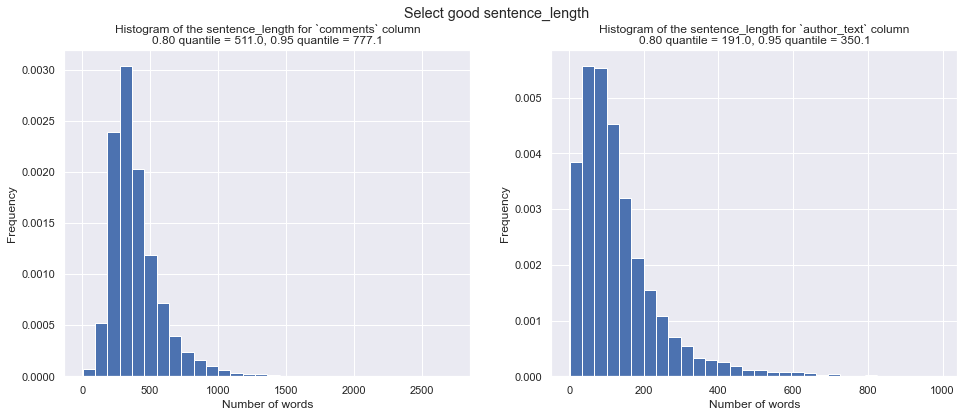

In [26]:
comments_lenght = X['comments'].str.split().apply(len).to_numpy()
author_lenght = X['author_text'].str.split().apply(len).to_numpy()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Select good sentence_length')

ax1.hist(comments_lenght, 30, density=True)
ax1.set_xlabel("Number of words")
ax1.set_ylabel("Frequency")
ax1.set_title("Histogram of the sentence_length for `comments` column\n" +
              "0.80 quantile = {:.1f}, ".format(np.quantile(comments_lenght, 0.8)) +
              "0.95 quantile = {:.1f}".format(np.quantile(comments_lenght, 0.95)))

ax2.hist(author_lenght, 30, density=True)
ax2.set_xlabel("Number of words")
ax2.set_ylabel("Frequency")
ax2.set_title("Histogram of the sentence_length for `author_text` column\n" +
              "0.80 quantile = {:.1f}, ".format(np.quantile(author_lenght, 0.8)) +
              "0.95 quantile = {:.1f}".format(np.quantile(author_lenght, 0.95)))

In [27]:
# Size of the vocabulary
# The layer will consider only the 'max_tokens' top popular words
max_tokens = 10000

# Maximum number of words in a sentence
# Longer sentences will be truncated, shorter ones will be pad
sentence_length_author = 350
sentence_length_comments = 750

### author_text_data

In [28]:
vectorizer_author, author_text_data_train = preprocess_text(X_train['author_text'],
                                                            max_tokens, sentence_length_author,
                                                            test=False)
author_text_data_train.shape

TensorShape([14818, 350])

In [29]:
_, author_text_data_test = preprocess_text(X_test['author_text'],
                                           max_tokens, sentence_length_author,
                                           test=True, vectorizer=vectorizer_author)
author_text_data_test.shape

TensorShape([1000, 350])

In [30]:
vocabulary_author = vectorizer_author.get_vocabulary()

### comments_data

In [31]:
vectorizer_comments, comments_data_train = preprocess_text(X_train['comments'],
                                                           max_tokens, sentence_length_comments,
                                                           test=False)
comments_data_train.shape

TensorShape([14818, 750])

In [32]:
_, comments_data_test = preprocess_text(X_test['comments'],
                                        max_tokens, sentence_length_comments,
                                        test=True, vectorizer=vectorizer_comments)
comments_data_test.shape

TensorShape([1000, 750])

In [33]:
vocabulary_comments = vectorizer_comments.get_vocabulary()

## Create pre-trained Endebbings layers

In [34]:
embeddings_1 = pretrained_embedding_layer(vocabulary_author,
                                          name='pretrained_embeddings_for_author_text',
                                          path_to_emb_file='embeddings/fastText_id_22/model.txt',
                                          emb_dim=300)

C:\Users\dmytro\AppData\Local\Temp/ipykernel_7976/3528643408.py:31: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs, "f", sep=" ")


Found 290990 word vectors.
Converted 7046 words (2954 misses)


In [35]:
embeddings_2 = pretrained_embedding_layer(vocabulary_comments,
                                          name='pretrained_embeddings_for_comments',
                                          path_to_emb_file='embeddings/fastText_id_22/model.txt',
                                          emb_dim=300)

C:\Users\dmytro\AppData\Local\Temp/ipykernel_7976/3528643408.py:31: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  coefs = np.fromstring(coefs, "f", sep=" ")


Found 290990 word vectors.
Converted 9411 words (589 misses)


# Saving data to disk

In [36]:
save_folder = 'models/data'

In [37]:
# dataset in csv format
df_final.to_csv(f'{save_folder}/final.csv', index=False)

In [38]:
np.save(f'{save_folder}/y_train.npy', y_train)
np.save(f'{save_folder}/y_test.npy', y_test)

np.save(f'{save_folder}/numeric_data_train.npy', numeric_data_train)
np.save(f'{save_folder}/numeric_data_test.npy', numeric_data_test)

In [39]:
pickle.dump(author_text_data_train, 
            open(f'{save_folder}/author_text_data_train.p', 'wb'))
pickle.dump(author_text_data_test, 
            open(f'{save_folder}/author_text_data_test.p', 'wb'))

pickle.dump(comments_data_train, 
            open(f'{save_folder}/comments_data_train.p', 'wb'))
pickle.dump(comments_data_test, 
            open(f'{save_folder}/comments_data_test.p', 'wb'))

In [40]:
pickle.dump(embeddings_1, open(f'{save_folder}/embeddings_1.p', 'wb'))
pickle.dump(embeddings_2, open(f'{save_folder}/embeddings_2.p', 'wb'))

In [41]:
# load data from numpy
# var = np.load('filename.npy')

# from pickle
# var = pickle.load(open("filename.p", 'rb'))